# SMCNOD - Member Probability

In [33]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat

## Data
with quality cuts

In [34]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5

absdev_1700d_0,absdev_580v_0,alpha1,alpha16,alpha50,alpha84,alpha99,alpha_kurt,alpha_mean,alpha_skew,alpha_std,chisq_1700d_0,chisq_580v_0,chisq_cont_1700d_0,chisq_cont_580v_0,comment,dec,feh1,feh16,feh50,feh84,feh99,feh_kurt,feh_mean,feh_skew,feh_std,field,fig_name,fileinfo,logg1,logg16,logg50,logg84,logg99,logg_kurt,logg_mean,logg_skew,logg_std,name,nspec_1700d,nspec_580v,prior_type,proc_file_list,ra,redchisq_1700d_0,redchisq_580v_0,sn_1700d_0,sn_580v_0,teff1,teff16,teff50,teff84,teff99,teff_kurt,teff_mean,teff_skew,teff_std,utmjd,utmjd_mean,vel1,vel16,vel50,vel84,vel99,vel_blue1,vel_blue16,vel_blue50,vel_blue84,vel_blue99,vel_blue_kurt,vel_blue_mean,vel_blue_skew,vel_blue_std,vel_kurt,vel_mean,vel_skew,vel_std,fname,absdev_580v_1,chisq_580v_1,chisq_cont_580v_1,redchisq_580v_1,sn_580v_1,absdev_1700d_1,chisq_1700d_1,chisq_cont_1700d_1,redchisq_1700d_1,sn_1700d_1,absdev_1700d_2,chisq_1700d_2,chisq_cont_1700d_2,redchisq_1700d_2,sn_1700d_2,absdev_580v_2,chisq_580v_2,chisq_cont_580v_2,redchisq_580v_2,sn_580v_2,absdev_1700d_3,absdev_1700d_4,absdev_1700d_5,absdev_580v_3,absdev_580v_4,absdev_580v_5,chisq_1700d_3,chisq_1700d_4,chisq_1700d_5,chisq_580v_3,chisq_580v_4,chisq_580v_5,chisq_cont_1700d_3,chisq_cont_1700d_4,chisq_cont_1700d_5,chisq_cont_580v_3,chisq_cont_580v_4,chisq_cont_580v_5,redchisq_1700d_3,redchisq_1700d_4,redchisq_1700d_5,redchisq_580v_3,redchisq_580v_4,redchisq_580v_5,sn_1700d_3,sn_1700d_4,sn_1700d_5,sn_580v_3,sn_580v_4,sn_580v_5,ebv,gaia_source_id,dr2_source_id,phot_bp_rp_excess_factor,parallax,parallax_error,phot_g_mean_mag,source_id,pmra,pmdec,pmra_error,pmdec_error,pmra_pmdec_corr,phot_bp_mean_mag,phot_rp_mean_mag,r_med_geo,r_lo_geo,r_hi_geo,r_med_photogeo,r_lo_photogeo,r_hi_photogeo,bjdist_flag,w1mpro,w2mpro,w1sigmpro,w2sigmpro,j_2mass,h_2mass,k_2mass,u_skm,e_u_skm,v_skm,e_v_skm,g_skm,e_g_skm,r_skm,e_r_skm,i_skm,e_i_skm,z_skm,e_z_skm,starhorse_dist05,starhorse_dist16,starhorse_dist50,starhorse_dist84,starhorse_dist95,decam_g,decam_r,decam_i,decam_z,decam_phot_src_bits,qso_flag_wise,priority,object_name,sesar_s3ab,sesar_s3c,gaia_rr,p_bhb_decals,best_chisq_580v,best_absdev_580v,best_sn_580v,best_chisq_1700d,best_absdev_1700d,best_sn_1700d,good_star_pb,good_star,vel_calib,vel_calib_std,feh_calib_std,mass1,mass16,mass50,mass84,mass99,mass_mean,mass_std,mass_kurt,mass_skew,logage1,logage16,logage50,logage84,logage99,logage_mean,logage_std,logage_kurt,logage_skew,sp_feh1,sp_feh16,sp_feh50,sp_feh84,sp_feh99,sp_feh_mean,sp_feh_std,sp_feh_kurt,sp_feh_skew,sp_alpha1,sp_alpha16,sp_alpha50,sp_alpha84,sp_alpha99,sp_alpha_mean,sp_alpha_std,sp_alpha_kurt,sp_alpha_skew,logdist1,logdist16,logdist50,logdist84,logdist99,logdist_mean,logdist_std,logdist_kurt,logdist_skew,lmag_sys1,lmag_sys16,lmag_sys50,lmag_sys84,lmag_sys99,lmag_sys_mean,lmag_sys_std,lmag_sys_kurt,lmag_sys_skew,npost,sp_feh_calib_std,GDR3_solution_id,GDR3_source_id,GDR3_classprob_dsc_combmod_quasar,GDR3_classprob_dsc_combmod_galaxy,GDR3_classprob_dsc_combmod_star,GDR3_classprob_dsc_combmod_whitedwarf,GDR3_classprob_dsc_combmod_binarystar,GDR3_classprob_dsc_specmod_quasar,GDR3_classprob_dsc_specmod_galaxy,GDR3_classprob_dsc_specmod_star,GDR3_classprob_dsc_specmod_whitedwarf,GDR3_classprob_dsc_specmod_binarystar,GDR3_classprob_dsc_allosmod_quasar,GDR3_classprob_dsc_allosmod_galaxy,GDR3_classprob_dsc_allosmod_star,GDR3_teff_gspphot,GDR3_teff_gspphot_lower,GDR3_teff_gspphot_upper,GDR3_logg_gspphot,GDR3_logg_gspphot_lower,GDR3_logg_gspphot_upper,GDR3_mh_gspphot,GDR3_mh_gspphot_lower,GDR3_mh_gspphot_upper,GDR3_distance_gspphot,GDR3_distance_gspphot_lower,GDR3_distance_gspphot_upper,GDR3_azero_gspphot,GDR3_azero_gspphot_lower,GDR3_azero_gspphot_upper,GDR3_ag_gspphot,GDR3_ag_gspphot_lower,GDR3_ag_gspphot_upper,GDR3_abp_gspphot,GDR3_abp_gspphot_lower,GDR3_abp_gspphot_upper,GDR3_arp_gspphot,GDR3_arp_gspphot_lower,GDR3_arp_gspphot_upper,GDR3_ebpminrp_gspphot,GDR3_ebpminrp_gspphot_lower,GDR3_ebpminrp_gspphot_upper,GDR3_mg_gspphot,GDR3_mg_gspphot_lower,GDR3_mg_gspphot_upper,GDR3

In [35]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
c6 = np.sqrt(table_cut['pmra']**2 + table_cut['pmdec']**2) < 10
high_quality = (c1 | c2) & c3 & c4 & c6
table_cut = table_cut[high_quality]
tab = table_cut
# subjective peak selection for member
metalpoor = table_cut['feh50'] < -1.5
sel_peak = (60 <table_cut['vel_calib']) & (table_cut['vel_calib'] < 125.5)
peak_pm = ( 0 < table_cut['pmra'][sel_peak] )  &  ( table_cut['pmra'][sel_peak] < 1.5) & (-1.75 < table_cut['pmdec'] [sel_peak]) & (table_cut['pmdec'] [sel_peak] < -0.6)
smcnod = table_cut[sel_peak][peak_pm]
tab_1 = smcnod

In [36]:
len(tab)

291

In [37]:
len(tab_1)

150

## Posterior Parameters
mcmc result from full model

In [38]:
pgal =  0.557
pbg1 =  0.392
vhel =  98.656
lsigv =  1.110
feh =  -1.857
lsigfeh =  -0.474
vbg1 =  171.098
lsigvbg1 =  1.931
fehbg1 =  -1.574
lsigfeh1 =  -0.300
vbg2 =  36.422
lsigvbg2 =  1.741
fehbg2 =  -0.841
lsigfeh2 =  -0.383

theta_opt = pgal, pbg1, vhel, lsigv, feh, lsigfeh, vbg1, lsigvbg1, fehbg1, lsigfeh1, vbg2, lsigvbg2, fehbg2, lsigfeh2

## Define Variables
The code define variables that are necessary for the next steps of the analysis, such as **radial velocity, metallicity, and proper motions**, and the respective errors, as well as creating arrays to store the proper motion data, and the covariance matrix. 

The code also assumes a uniform background and creates a dictionary containing some of these variables.

In [39]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]

In [40]:
def memprob(theta):
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2 = theta

    #lgal
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))    
    ## Compute log likelihood in fe
    lgal_feh = stats.norm.logpdf(feh, loc=feh, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2)) 
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh
    ## exp of log
    gal = np.exp(lgal)
    
    ## bg1
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))   
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))

    ## Combine the components
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh
    
    # bg2
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))

    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh
    
    # combine bg1 and bg2
    lbgtot = np.logaddexp(lbg1, lbg2)
    bg = np.exp(lbgtot)
    
    # member probability
    p = (gal*pgal)/((gal*pgal)+(1-pgal)*bg)
    return p

Now, check how many members we have are of "high" memberhsip probability.

To think about: what should the threshold for high memprob be set to?

In [53]:
sum(memprob(theta_opt) > 0.9)

134

In [42]:
sum(memprob(theta_opt) > 0.5)

187

In [43]:
# set the threshold to 0.5
tab['memberprob'] = memprob(theta_opt)
tab['membership'] = memprob(theta_opt) > 0.5
tab_good = tab[tab['memberprob'] > 0.5]
tab_bad = tab[tab['memberprob'] <= 0.5]

### Store the member data

In [44]:
# Save the member stars as a CSV file
# Convert to a pandas dataframe
df = tab_good.to_pandas()
df.to_csv('member_stars_NoPM.csv', index=False)
df_1 = tab_bad.to_pandas()
df_1.to_csv('non_member_stars_NoPM.csv', index=False)

## Visualizations

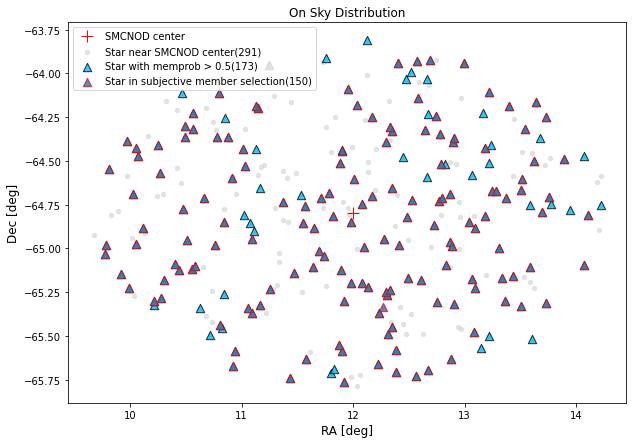

In [45]:
fig, ax = plt.subplots(figsize=(10,7))

plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['ra'],tab_good['dec'], marker='^', s=70, c='deepskyblue', ec='k', zorder=3, alpha=0.8,
        label='Star with memprob > 0.5(173)')
plt.scatter(tab_1['ra'],tab_1['dec'], marker='^', s=70, ec='r', zorder=3, alpha=0.8,
        label='Star in subjective member selection(150)')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()

In [46]:
# cut
g_band = tab['decam_g'] - 3.185 * tab['ebv']
r_band = tab['decam_r'] - 2.140 * tab['ebv']
i_band = tab['decam_i'] - 1.569 * tab['ebv']
g_cut = tab_good['decam_g'] - 3.185 * tab_good['ebv']
r_cut = tab_good['decam_r'] - 2.140 * tab_good['ebv']
i_cut = tab_good['decam_i'] - 1.569 * tab_good['ebv']
table_iso = ascii.read('iso_a06.0_z0.00108.dat', header_start = 8)
g_iso = table_iso['DECam_g']
r_iso = table_iso['DECam_r']
# 18.96 ± 0.02 distance modulus in kpc
u_dm = 18.96

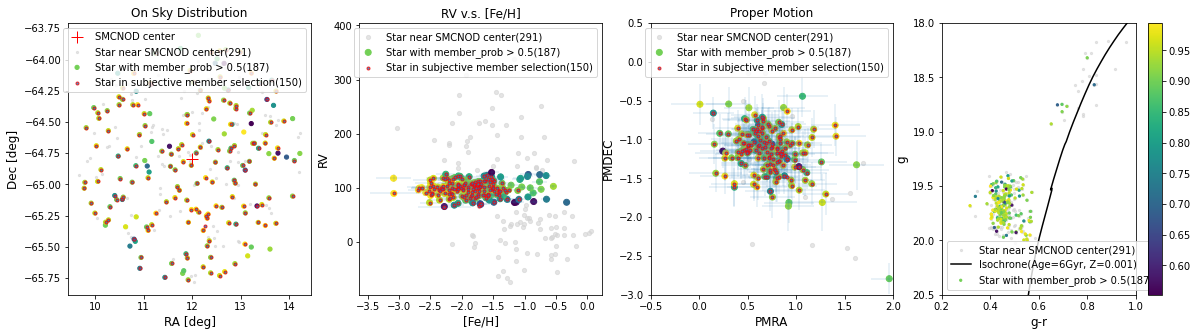

In [51]:
plt.figure(figsize=(20,5))
#plt.suptitle("Scatter Plot of Features", fontsize=20)
plt.subplot(1,4,1)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],
            marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['ra'],tab_good['dec'], 
            marker='.', s=70, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(187)')
plt.scatter(smcnod['ra'],smcnod['dec'], 
            marker='.',ec='r', zorder=3, alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()

plt.subplot(1,4,2)
plt.scatter(tab['feh50'],tab['vel_calib'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['feh50'], tab_good['vel_calib'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(187)')
plt.errorbar(tab_good['feh50'], tab_good['vel_calib'], xerr=tab_good['feh_std'], yerr=tab_good['vel_calib_std'], 
             fmt='None', marker='None',lw=0.2)
plt.scatter(smcnod['feh50'],smcnod['vel_calib'], 
            marker='.',ec='r', zorder=3, alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
#plt.ylim(50,150)
plt.title('RV v.s. [Fe/H]')
plt.legend()

plt.subplot(1,4,3)
plt.scatter(tab['pmra'],tab['pmdec'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['pmra'], tab_good['pmdec'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(187)')
plt.errorbar(tab_good['pmra'], tab_good['pmdec'], xerr=tab_good['pmra_error'], yerr=tab_good['pmdec_error'], 
             fmt='None', marker='None',lw=0.2)
plt.scatter(smcnod['pmra'],smcnod['pmdec'], 
            marker='.',ec='r', zorder=3, alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
plt.xlim(-0.5,2)
plt.ylim(-3,0.5)
plt.legend()


plt.legend()
plt.subplot(1,4,4)
plt.scatter(g_band - r_band, g_band,marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.plot(g_iso - r_iso, g_iso + u_dm, '-k', label = 'Isochrone(Age=6Gyr, Z=0.001)')
plt.scatter(g_cut - r_cut, g_cut, marker='.', s=20, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(187)')
plt.xlim(0.2,1.0)
plt.ylim(18,20.5)
plt.xlabel('g-r', size = 12)
plt.ylabel('g', size = 12)
plt.gca().invert_yaxis()
plt.legend()
plt.colorbar()
plt.savefig('memberselect.png')
plt.show()

In [28]:
g_band = tab_good['decam_g'] - 3.185 * tab_good['ebv']
r_band = tab_good['decam_r'] - 2.140 * tab_good['ebv']
i_band = tab_good['decam_i'] - 1.569 * tab_good['ebv']
g_r = g_band - r_band
tab_good1 = tab_good[(g_band > 17) & (g_band < 23) & (g_r > 0.5) & (g_r < 1.2)]
tab_good1 = tab_good
# get the desired data
logg = tab_good1['logg50']
Teff = tab_good1['teff50']
FeH = tab_good1['feh50']

/opt/anaconda3/lib/python3.9/site-packages/astroML/stats/_binned_statistic.py:321: RuntimeWarning: invalid value encountered in true_divide
  result[a] /= flatcount
/var/folders/9w/8jsv_f1j1t357nbjlwl197kr0000gn/T/ipykernel_35925/2635805365.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.contour(np.log10(N.T), levels, colors='k', linewidths=1,


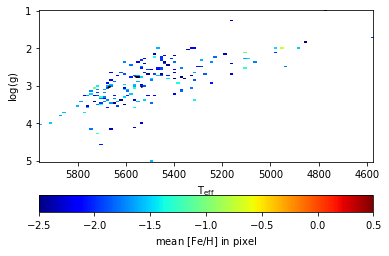

In [29]:
from astroML.stats import binned_statistic_2d
N, xedges, yedges = binned_statistic_2d(Teff, logg, FeH,
                                        'count', bins=100)
FeH_mean, xedges, yedges = binned_statistic_2d(Teff, logg, FeH,
                                               'mean', bins=100)

# Define custom colormaps: Set pixels with no sources to white
cmap = plt.cm.jet
cmap.set_bad('w', 1.)

cmap_multicolor = plt.cm.jet
cmap_multicolor.set_bad('w', 1.)

plt.imshow(FeH_mean.T, origin='lower',
           extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           aspect='auto', interpolation='nearest', cmap=cmap_multicolor)
plt.xlim(xedges[-1], xedges[0])
plt.ylim(yedges[-1], yedges[0])
plt.xlabel(r'$\mathrm{T_{eff}}$')
plt.ylabel(r'$\mathrm{log(g)}$')

cb = plt.colorbar(ticks=np.arange(-2.5, 1, 0.5),
                  format=r'$%.1f$', orientation='horizontal')
cb.set_label(r'$\mathrm{mean\ [Fe/H]\ in\ pixel}$')
plt.clim(-2.5, 0.5)

# Draw density contours over the colors
levels = np.linspace(0, np.log10(N.max()), 7)[2:]
plt.contour(np.log10(N.T), levels, colors='k', linewidths=1,
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
plt.show()